# Bayesian Optimisation

For black-box optimisation i.e. find the minimum of an unknown function $f$ which is expensive to evaluate. BO learns a GP as a surrogate function and uses our belief in this surrogate as a guide to our search offering improvements over random search.

Objective: $ \hat{x} = argmin_xf(x) $

GP predictive posterior: $ p(f_*|\mathcal{D},x_*,\theta) = \mathcal{N}(\mu_{x_*|x}, K_{x_*|x}) $ where $ \mathcal{D}=\{x,f\} $, the observed data.

The acquisition function $\alpha$ encodes the strategy of how to utilise our knowledge about the unknown function (via our belief in the surrogate) in order to decide where to next query the function. The acquisition function needs to be cheap to evaluate and should balance exploration and exploitation.
- Thompson sampling (draw a sample from the GP posterior and find the minimum): $ -\alpha(x) \sim p(f|\mathcal{D},x, \theta)$
- Upper Confidence Bound (linear combination of GP mean and variance): $ \alpha(x) = -\mu(x) + \beta \sigma(x) $
- Probability of Improvement (utility function $u(x)=1$ if $f(x) \leq f(x^*)$ else $0$): $ \alpha = p(f(x) \leq f(x^*) = \int_{-\infty}^{f(x^*)} \mathcal{N}(f|\mu(x),K(x,x))\ df = \Phi(f(x^*)|\mu(x),K(x,x)) $ where $\Phi$ is the cumulative density function
- Expected Improvement (utility is proportional to expected improved $u(x)=max(0,f(x^*)-f(x)$): $ \alpha(x) = \int_{-\infty}^{f(x^*)} (f(x^*)-f) \mathcal{N}(f|\mu(x),K(x,x))\ df = (f(x^*)-\mu(x)) \Phi(f(x^*)|\mu(x),K(x,x)) + K(x,x) \mathcal{N}(f(x^*)|\mu(x),K(x,x)) $

In [326]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import norm

(0.0, 1.0)

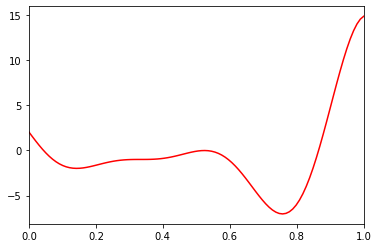

In [327]:
def squared_exponential(var, l):
    return lambda x1, x2: var * np.exp(-np.power(cdist(x1, x2), 2) / l**2)

def surrogate_belief(x, f, x_star, theta):
    var, l, noise = theta[0], theta[1], theta[2]
    kernel = squared_exponential(var, l)
    mu_star = kernel(x_star, x) @ np.linalg.inv(kernel(x, x) + noise * np.identity(len(x))) @ f
    varSigma_star = kernel(x_star, x_star) - kernel(x_star, x) @ np.linalg.inv(kernel(x, x) + noise * np.identity(len(x))) @ kernel(x, x_star)
    return mu_star, varSigma_star

def func(A=1, B=0, C=0):
    return lambda x: A*(6*x-2)**2*np.sin(12*x-4) + B*(x-0.5) + C
f = func(C=-1)

def plot_surrogate(mu, var, x, alpha=None, scale=1, thompson=False):
    fig, ax = plt.subplots()
    ax.scatter(x, f(x))
    ax.plot(x_star, f(x_star), c='r')
    ax.plot(x_star, mu, c='cyan')
    ax.fill_between(x_star.flatten(), mu.flatten() - np.diag(var).flatten(), mu.flatten() + np.diag(var).flatten(), alpha=0.1, color='cyan')
    if alpha is not None:
        ax.plot(x_star, scale*alpha, c='m')
        if thompson is False:
            ax.scatter(x_star[np.argmax(alpha)], scale*np.max(alpha), c='m', marker='x')
        else:
            ax.scatter(x_star[np.argmin(alpha)], scale*np.min(alpha), c='m', marker='x')
    ax.set_xlim(0, 1)
    plt.show()

# kernel hyperparams
theta = [4, 0.2, 0.1]

x_star = np.linspace(0, 1, 100).reshape(-1, 1)
fig, ax = plt.subplots()
ax.plot(x_star, f(x_star), c='r')
ax.set_xlim(0, 1)

### Random search

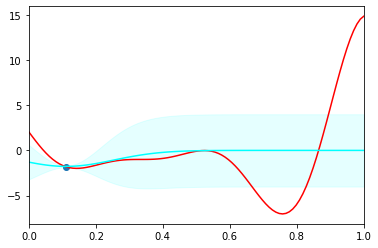

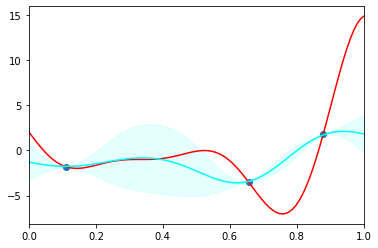

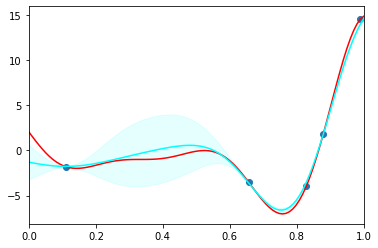

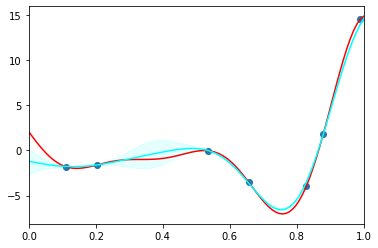

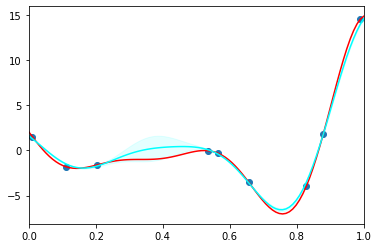

Minimum at 0.76 with value -6.57


In [328]:
index = np.random.permutation(len(x_star))
for i in range(10):
    x = x_star[index[:i+1]].reshape(-1, 1)
    mu, var = surrogate_belief(x, f(x), x_star, theta)
    if i % 2 == 0:
        plot_surrogate(mu, var, x)
print(f'Minimum at {round(x_star[np.argmin(mu)].item(), 2)} with value {round(np.min(mu), 2)}')

### Bayesian Optimisation
1) Thompson samping

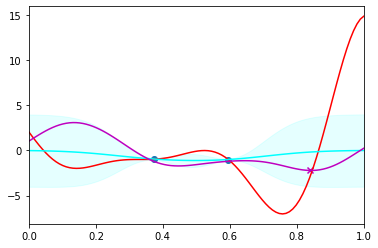

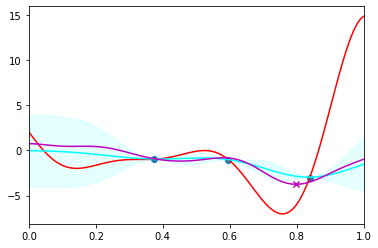

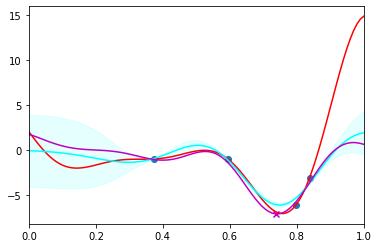

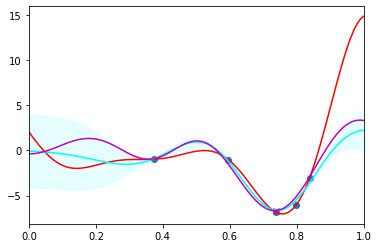

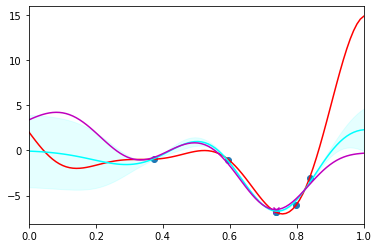

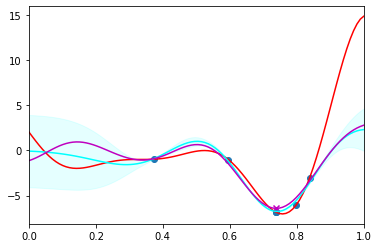

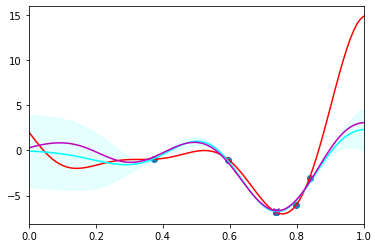

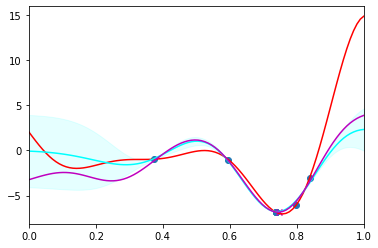

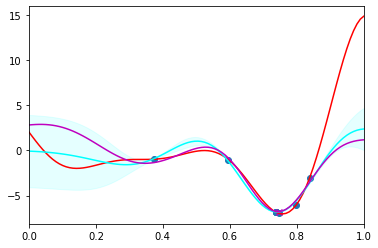

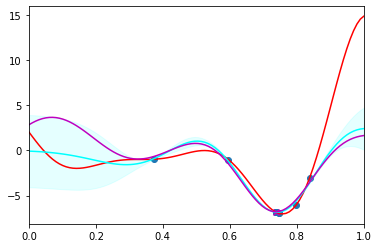

In [329]:
def thompson_samping(mu, var):
    return -np.random.multivariate_normal(mu.flatten(), var, 1).reshape(-1, 1)

x = x_star[np.random.permutation(len(x_star))[:2]].reshape(-1, 1)
for i in range(10):
    mu, var = surrogate_belief(x, f(x), x_star, theta)
    alpha = thompson_samping(mu, var)
    plot_surrogate(mu, var, x, -alpha, thompson=True)
    x_next = x_star[np.argmax(alpha)].reshape(-1, 1)
    x = np.concatenate((x, x_next))

2) Upper confidence bound (UCB)

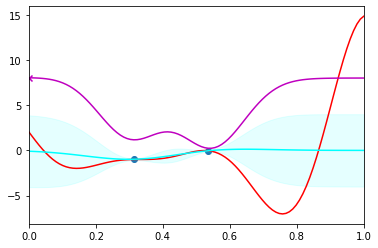

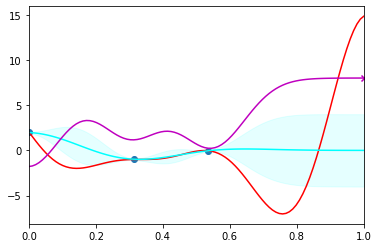

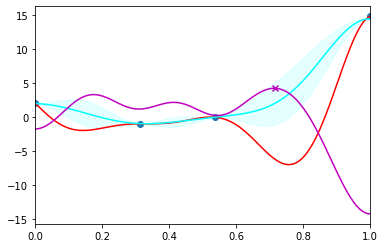

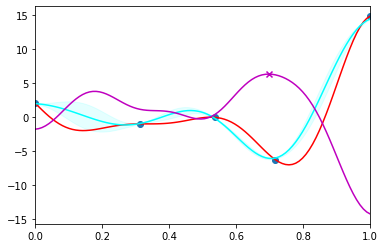

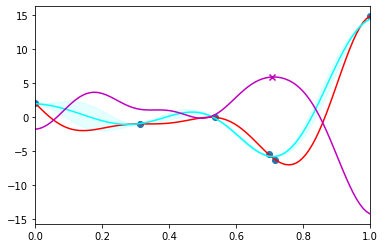

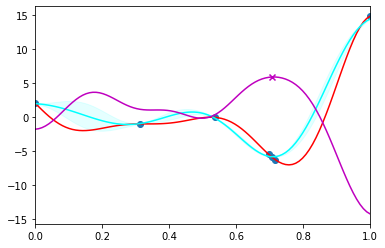

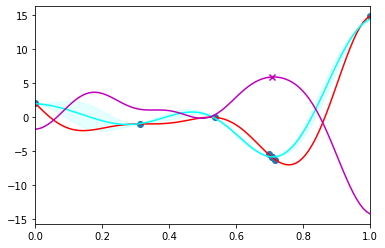

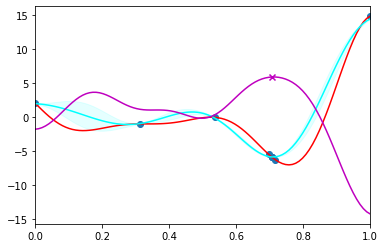

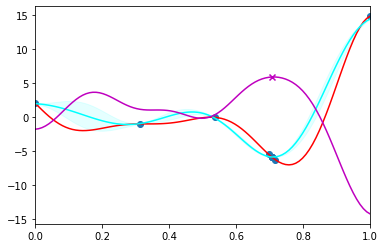

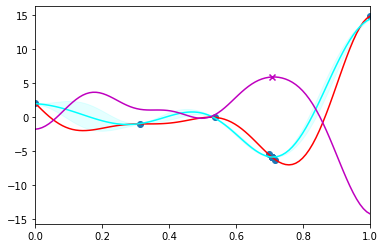

In [330]:
def ucb(mu, var, beta=1):
    return -mu.flatten() + beta * np.diag(var)

x = x_star[np.random.permutation(len(x_star))[:2]].reshape(-1, 1)
for i in range(10):
    mu, var = surrogate_belief(x, f(x), x_star, theta)
    alpha = ucb(mu, var, beta=2)
    plot_surrogate(mu, var, x, alpha)
    x_next = x_star[np.argmax(alpha)].reshape(-1, 1)
    x = np.concatenate((x, x_next))

3. Probability of improvement

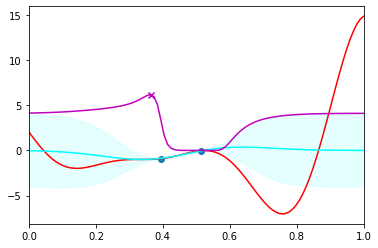

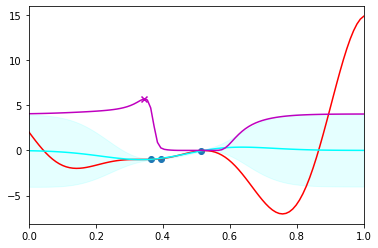

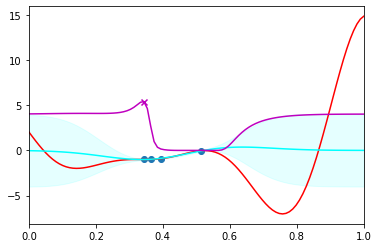

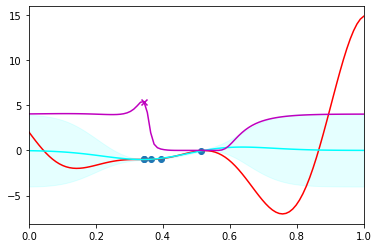

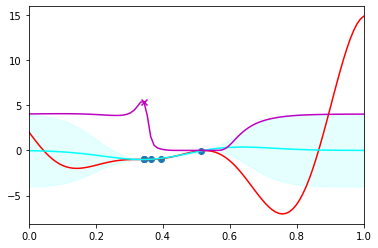

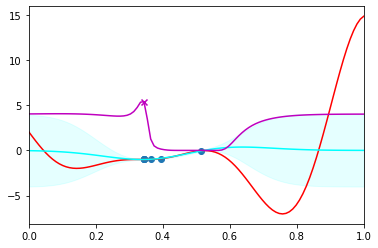

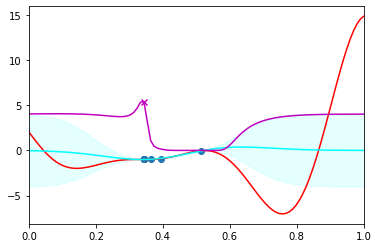

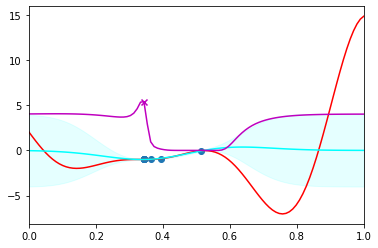

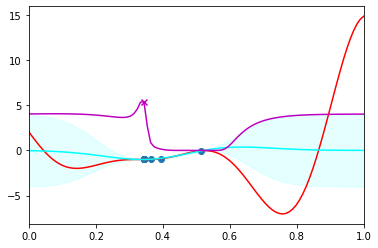

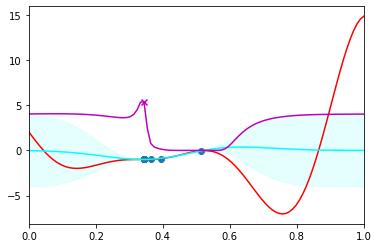

In [333]:
def prob_improvement(mu, var, f_best):
    return norm.cdf(f_best, mu.flatten(), np.diag(var)).flatten()

x = x_star[np.random.permutation(len(x_star))[:2]].reshape(-1, 1)
f_best = np.min(f(x))
for i in range(10):
    mu, var = surrogate_belief(x, f(x), x_star, theta)
    alpha = prob_improvement(mu, var, f_best)
    plot_surrogate(mu, var, x, alpha, scale=10)
    x_next = x_star[np.argmax(alpha)].reshape(-1, 1)
    x = np.concatenate((x, x_next))
    f_best = min(f_best, f(x_next))

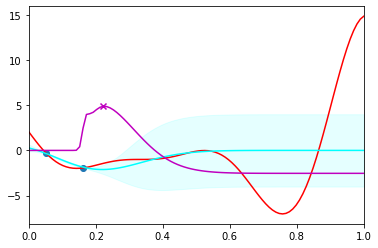

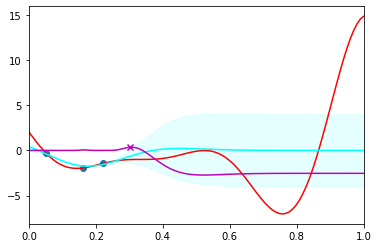

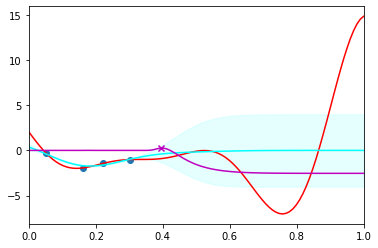

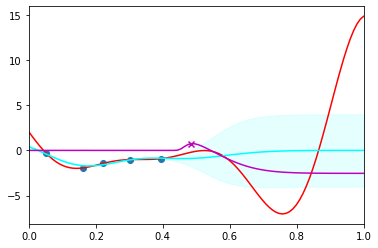

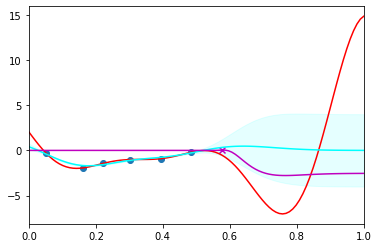

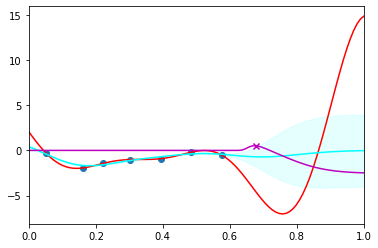

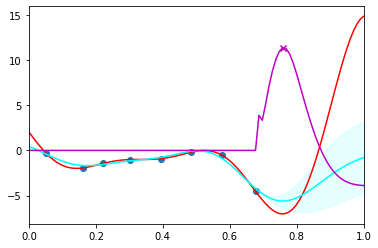

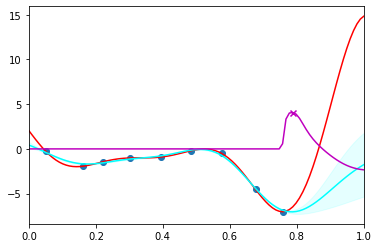

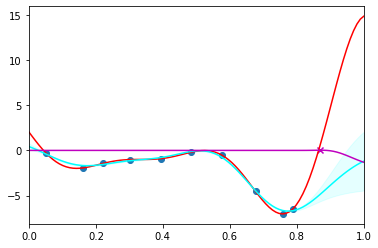

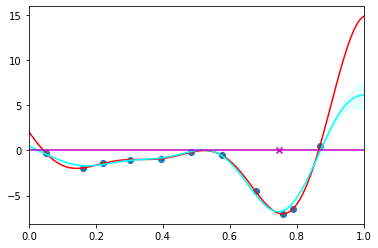

In [335]:
def expected_improvement(mu, var, f_best):
    exploit = (f_best - mu.flatten()) * norm.cdf(f_best, mu.flatten(), np.diag(var))
    explore = np.diag(var) * norm.pdf(f_best, mu.flatten(), np.diag(var))
    return (exploit + explore).flatten()

x = x_star[np.random.permutation(len(x_star))[:2]].reshape(-1, 1)
f_best = np.min(f(x))
for i in range(10):
    mu, var = surrogate_belief(x, f(x), x_star, theta)
    alpha = expected_improvement(mu, var, f_best)
    plot_surrogate(mu, var, x, alpha, scale=10)
    x_next = x_star[np.argmax(alpha)].reshape(-1, 1)
    x = np.concatenate((x, x_next))
    f_best = min(f_best, f(x_next))